In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
import pickle
# Tải data đã lưu
split_file = "splitted_data.pkl"
print("Tải dữ liệu đã lưu từ:", split_file)

with open(split_file, "rb") as f:
    data_splits = pickle.load(f)

# Lấy các tập dữ liệu từ dictionary
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]
X_train_val = data_splits["X_train_val"]
y_train_val = data_splits["y_train_val"]

Tải dữ liệu đã lưu từ: splitted_data.pkl


In [3]:
import numpy as np
# Kiểm tra phân phối của lớp
print("Phân phối lớp trong tập huấn luyện:")
unique, counts = np.unique(y_train_val, return_counts=True)
print(dict(zip(unique, counts)))
print(f"Tỷ lệ dữ liệu dương/âm: 1:{counts[0]/counts[1]:.2f}")

Phân phối lớp trong tập huấn luyện:
{0: 26815, 1: 169}
Tỷ lệ dữ liệu dương/âm: 1:158.67


In [4]:
# Chuẩn hóa & reshape cho Conv1D
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_train)
X_va_s = scaler.transform(X_val)
X_te_s = scaler.transform(X_test)

# Reshape thành (samples, features, 1)
X_tr = X_tr_s.reshape(-1, X_tr_s.shape[1], 1)
X_va = X_va_s.reshape(-1, X_va_s.shape[1], 1)
X_te = X_te_s.reshape(-1, X_te_s.shape[1], 1)

y_tr, y_va, y_te = y_train, y_val, y_test

In [5]:
# Xây dựng mô hình mẫu
# - 3 block Conv1D, filters lần lượt 32→64→128
# - FC layers 512→256, dropout 0.3
# - Focal loss cố định γ=2.0, α=0.25
def focal_loss_fixed(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
    alpha_t = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
    focal = -alpha_t * K.pow(1.0 - p_t, gamma) * K.log(p_t)
    return K.mean(focal)

model = Sequential([
    Conv1D(32, 3, activation='relu', padding='same', input_shape=(X_tr.shape[1],1)),
    BatchNormalization(),
    Conv1D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=focal_loss_fixed,
    metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            128       
                                                                 
 batch_normalization (Batch  (None, 10, 32)            128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            3104      
                                                                 
 batch_normalization_1 (Bat  (None, 10, 32)            128       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 32)             0         
 D)                                                              
                                                      

In [6]:
# Train mô hình
model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/20

317/317 [==============================] - 7s 10ms/step - loss: 0.0059 - auc: 0.7848 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0031 - val_auc: 0.9072 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
317/317 [==============================] - 3s 8ms/step - loss: 0.0036 - auc: 0.8713 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0035 - val_auc: 0.8800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
317/317 [==============================] - 3s 10ms/step - loss: 0.0035 - auc: 0.8803 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0029 - val_auc: 0.9310 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
317/317 [==============================] - 3s 10ms/step - loss: 0.0031 - auc: 0.9116 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0029 - val_auc: 0.9178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
317/317 [==============================] - 3s 10ms/step - loss: 0

211/211 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.00      0.00      0.00        42

    accuracy                           0.99      6747
   macro avg       0.50      0.50      0.50      6747
weighted avg       0.99      0.99      0.99      6747



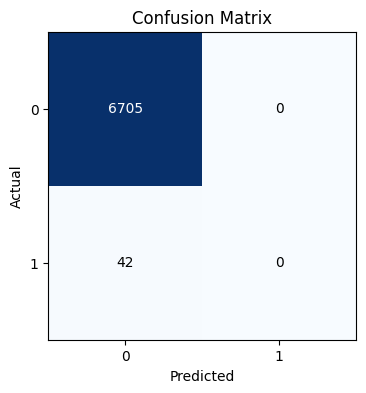

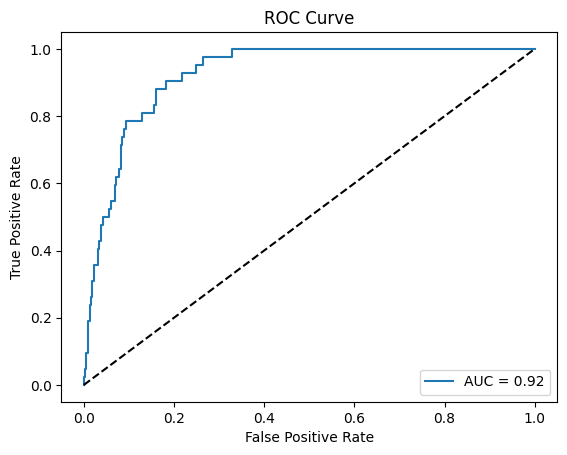

In [8]:
# Đánh giá trên test set
# In Classification Report
# Vẽ Confusion Matrix và ROC Curve

y_prob = model.predict(X_te).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Classification Report
print(classification_report(y_te, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_te, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()